In [1]:
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from collections import Counter

np.random.seed(11)

# Loading and pre-processing the data

In [2]:
# Loading the datasets
test_data = read_csv("ValidationData.csv", header=0, delimiter=',')
train_data = read_csv("TrainingData.csv", header=0, delimiter=',')

In [3]:
# Drop attributes we are not gonna use        
test_data.drop(['SPACEID','RELATIVEPOSITION','USERID','PHONEID','TIMESTAMP'], axis=1, inplace=True)
train_data.drop(['SPACEID','RELATIVEPOSITION','USERID','PHONEID','TIMESTAMP'], axis=1, inplace=True)

# Drop attributes that remain constant in either set because they will not carry any information
for col in train_data.columns:
    if (len(train_data[col].unique()) == 1 or len(test_data[col].unique()) == 1):
        test_data.drop([col], axis=1, inplace=True)
        train_data.drop([col], axis=1, inplace=True)

In [4]:
# Looking for missing values
print("Train data missing values:", train_data.isnull().values.any())
print("Test data missing values:", test_data.isnull().values.any())

Train data missing values: False
Test data missing values: False


In [5]:
#-105dB would actually mean 10**(-8.5)% or ~0.000000003% of intensity so it 
#is safe to assume -105dB = 0 = No Intensity

test_data.replace({100:-100}, inplace=True)
test_data.iloc[:,0:312].clip(-100,0,inplace=True)
train_data.replace({100:-100}, inplace=True)
train_data.iloc[:,0:312].clip(-100,0,inplace=True)

In [6]:
print(train_data.shape)
print(test_data.shape)

(19937, 316)
(1111, 316)


Text(0.5, 1.0, 'Test data')

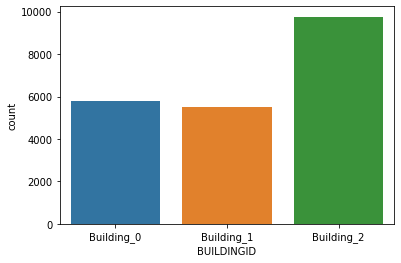

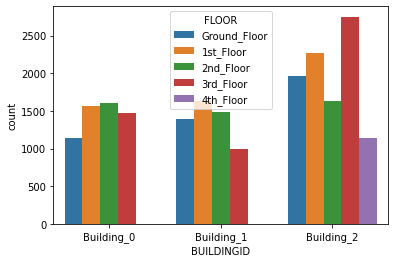

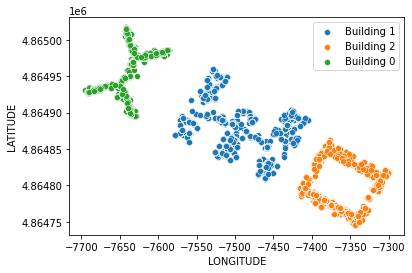

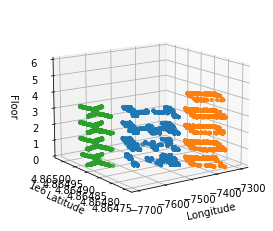

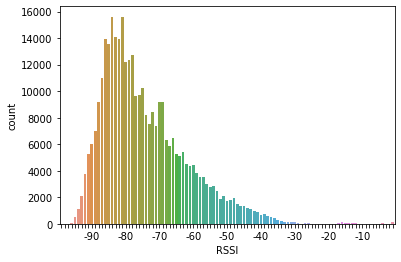

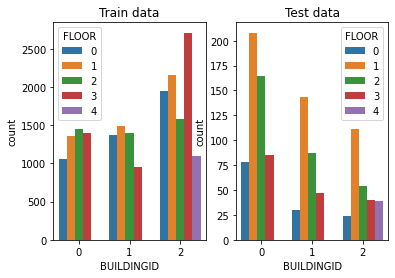

In [7]:
df=pd.concat([test_data, train_data], axis=0)
plot_data = pd.concat([test_data, train_data], axis=0)
plot_data["FLOOR"].replace({1: "1st_Floor", 2: "2nd_Floor", 0 : "Ground_Floor", 3 : "3rd_Floor", 4 : "4th_Floor"}, inplace=True)
plot_data["BUILDINGID"].replace({1: "Building_1", 2: "Building_2", 0 : "Building_0"}, inplace=True)
Floor_order=["Ground_Floor", "1st_Floor", "2nd_Floor", "3rd_Floor", "4th_Floor"]
Building_order=["Building_0", "Building_1", "Building_2"]

plt.figure(1)
sn.countplot(x="BUILDINGID", data=plot_data, order=Building_order)
#plt.savefig('figura1.eps', format='eps')

plt.figure(2)
sn.countplot(x="BUILDINGID",hue="FLOOR", data=plot_data, hue_order=Floor_order, order=Building_order)
#plt.savefig('figura2.eps', format='eps')

plt.figure(3)
ax=sn.scatterplot(x="LONGITUDE", y="LATITUDE", data=plot_data[plot_data.BUILDINGID=="Building_1"], label="Building 1")
sn.scatterplot(x="LONGITUDE", y="LATITUDE", data=plot_data[plot_data.BUILDINGID=="Building_2"], label="Building 2")
sn.scatterplot(x="LONGITUDE", y="LATITUDE", data=plot_data[plot_data.BUILDINGID=="Building_0"], label="Building 0")
ax.legend()
#plt.savefig('figura3.eps', format='eps')

fig=plt.figure(4)
ax=fig.add_subplot(111, projection = '3d')
ax.scatter(df.LONGITUDE[df.BUILDINGID==1],df.LATITUDE[df.BUILDINGID==1],df.FLOOR[df.BUILDINGID==1],s=10)
ax.scatter(df.LONGITUDE[df.BUILDINGID==2],df.LATITUDE[df.BUILDINGID==2],df.FLOOR[df.BUILDINGID==2],s=10)
ax.scatter(df.LONGITUDE[df.BUILDINGID==0],df.LATITUDE[df.BUILDINGID==0],df.FLOOR[df.BUILDINGID==0],s=10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Floor")
ax.view_init(elev=14, azim=-125)
ax.set_zlim(0,6)
#plt.savefig('figura4.eps', format='eps')


X_df = plot_data.iloc[:,0:312]
countRSSI=pd.DataFrame()
for i in range(312):
    countRSSI=pd.concat([countRSSI,X_df.iloc[:, i][X_df.iloc[:,i]!=-100]], axis=0)

tt=[]
for i in range (100):
    if (i%10==0):
        tt.append(str(-i))
    else:
        tt.append("")
tt=tt[::-1]
tt.pop()

fig=plt.figure(5)
ax=sn.countplot(x=0,data=countRSSI)
ax.set(xticklabels=tt, xlabel="RSSI")
#plt.savefig('figura5.eps', format='eps')


fig, axes = plt.subplots(1, 2)
sn.countplot(ax=axes[0], x="BUILDINGID",hue="FLOOR", data=train_data, hue_order=[0, 1, 2, 3, 4], order=[0, 1, 2])
axes[0].set_title("Train data")
sn.countplot(ax=axes[1], x="BUILDINGID",hue="FLOOR", data=test_data, hue_order=[0, 1, 2, 3, 4], order=[0, 1, 2])
axes[1].set_title("Test data")
#plt.savefig('figura6.eps', format='eps')

# Let's start testing some methods...

In [8]:
#Separate into x,y
X_train   = train_data.iloc[:,0:312]
Lon_train = train_data.iloc[:,312]
Lat_train = train_data.iloc[:,313]
Flo_train = train_data.iloc[:,314]
Bui_train = train_data.iloc[:,315]

X_test   = test_data.iloc[:,0:312]
Lon_test = test_data.iloc[:,312]
Lat_test = test_data.iloc[:,313]
Flo_test = test_data.iloc[:,314]
Bui_test = test_data.iloc[:,315]

### PCA before clustering

In [11]:
from sklearn.preprocessing import minmax_scale
pca = PCA();
# We scale the data to improve PCA performance. 
pca.fit(X_train);
components = np.sum(np.cumsum(pca.explained_variance_ratio_) <= 0.9)
print('If we maintain 90% of the variance we obtain {} components'.format(components))
pca = PCA(n_components=components);
X_train_pca = pca.fit_transform(X_train);
X_test_pca = pca.transform(X_test)
df = pd.DataFrame(X_train_pca)

print('Original shape:', X_train.shape,'New shape:',X_train_pca.shape)

If we maintain 90% of the variance we obtain 54 components
Original shape: (19937, 312) New shape: (19937, 54)


In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=3, random_state=123)
gauss = GaussianMixture(n_components=3,
                        covariance_type='diag',
                        random_state=123)
gauss_full = GaussianMixture(n_components=3,
                             covariance_type='full',
                             random_state=123)

df["label_kmeans"] = kmeans.fit_predict(X_train_pca)
df["label_gauss"] = gauss.fit_predict(X_train_pca)
df["label_gauss_full"] = gauss_full.fit_predict(X_train_pca)
df["building"] = Bui_train

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


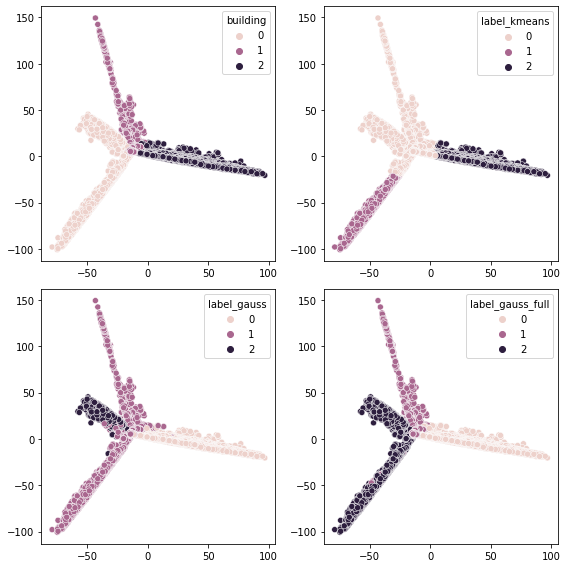

In [13]:
fig, axes = plt.subplots(2,2,figsize=(8,8));
sn.scatterplot(x=0, y=1, data = df, hue='building', ax=axes[0][0]).set(xlabel=None,ylabel=None)
sn.scatterplot(x=0, y=1, data = df, hue='label_kmeans', ax=axes[0][1]).set(xlabel=None,ylabel=None)
sn.scatterplot(x=0, y=1, data = df, hue='label_gauss', ax=axes[1][0]).set(xlabel=None,ylabel=None)
sn.scatterplot(x=0, y=1, data = df, hue='label_gauss_full', ax=axes[1][1]).set(xlabel=None,ylabel=None)
plt.tight_layout();
plt.savefig('clustering.eps')

In [14]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'K'))

results_df3 = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score']);

for k in [2,3,4,5,6,7,8,9]:
    kmeans = KMeans(n_clusters=k,
                    random_state=123);
    kmeans.fit(X_train_pca);

    CH = calinski_harabasz_score(X_train_pca, kmeans.labels_ );
    S = silhouette_score(X_train_pca, kmeans.labels_ );
    DB = davies_bouldin_score(X_train_pca, kmeans.labels_ );
    
    results_df3.loc[('kmeans', k),:] = [CH,S,DB];

In [15]:
results_df3

CH score Silhouette score  DB score
model  K                                        
kmeans 2  2131.585257          0.10198  2.891872
       3  1988.112711         0.126018  2.529757
       4  1999.040092         0.133417  2.046392
       5  1957.799108         0.150445  2.012259
       6  1747.917173         0.154129  1.935862
       7  1958.248126         0.174066  1.847894
       8  1910.892166         0.191349  1.730814
       9  1742.250091         0.187278  1.738536

In [16]:
results_df3 = results_df3.sort_index()
results_df3 = results_df3.astype(float)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


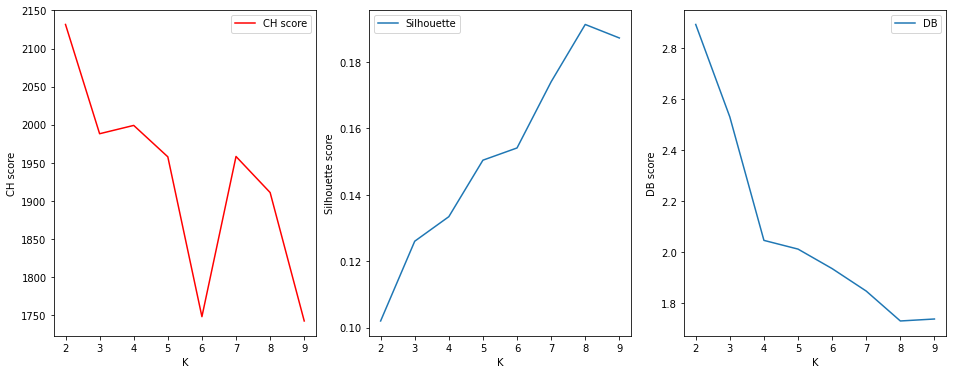

In [17]:
fig, ax = plt.subplots(1,3, figsize=(16,6))

sn.lineplot(x='K', y='CH score',data=results_df3.reset_index(),label='CH score', color='r', ax=ax[0]);
sn.lineplot(x='K', y='Silhouette score',data=results_df3.reset_index(),label='Silhouette',ax=ax[1]);
sn.lineplot(x='K', y='DB score',data=results_df3.reset_index(),label='DB', ax=ax[2]);

plt.savefig('clustering scores.eps')

In [18]:
for k in [2, 3, 4, 5, 6, 7, 8, 9]:
    gm =GaussianMixture(n_components=k, 
                        covariance_type='full',
                        random_state=123)
    gm.fit(X_train_pca);
    prediction = gm.predict(X_train_pca) 
    CH = calinski_harabasz_score(X_train_pca,prediction )
    S = silhouette_score(X_train_pca, prediction)
    DB = davies_bouldin_score(X_train_pca,prediction)
    
    results_df3.loc[('GM_full', k),:] = [CH,S,DB]
    
for k in [2, 3, 4, 5, 6, 7, 8, 9]:
    gm =GaussianMixture(n_components=k, 
                        covariance_type='diag',
                        random_state=123)
    gm.fit(X_train_pca);
    prediction = gm.predict(X_train_pca) 
    CH = calinski_harabasz_score(X_train_pca,prediction )
    S = silhouette_score(X_train_pca, prediction)
    DB = davies_bouldin_score(X_train_pca,prediction)
    
    results_df3.loc[('GM_diag', k),:] = [CH,S,DB]
    
results_df3

CH score  Silhouette score  DB score
model   K                                         
kmeans  2  2131.585257          0.101980  2.891872
        3  1988.112711          0.126018  2.529757
        4  1999.040092          0.133417  2.046392
        5  1957.799108          0.150445  2.012259
        6  1747.917173          0.154129  1.935862
        7  1958.248126          0.174066  1.847894
        8  1910.892166          0.191349  1.730814
        9  1742.250091          0.187278  1.738536
GM_full 2  1943.978911          0.094972  3.063565
        3  1714.955924          0.111467  2.833272
        4  1467.188030          0.093291  2.881033
        5  1328.181008          0.093769  2.716769
        6  1176.659254          0.075173  2.660340
        7  1461.758843          0.137669  2.240093
        8  1306.461941          0.123990  2.506523
        9  1261.891702          0.127692  2.385174
GM_diag 2  2022.471066          0.096521  2.997264
        3  1806.923630          0.127674  2.644547
        4  1378.577119          0.054135  3.442237
        5  1539.288251          0.073625  2.870419
        6  1443.032955          0.053991  2.683520
        7  1558.079039          0.092961  2.487983
        8  1413.928863         -0.010708  2.181451
        9  1360.808320          0.003614  2.110562

# Classification

In [9]:
def errorfunc(test,pred):
    error=0
    for i in range(len(test)):
        if (pred[i] != test[i]):
            error = error +abs(pred[i]-test[i])
    return error

def compute_classf_metrics(y, pred):
    return [accuracy_score(y, pred), f1_score(y, pred, average="macro"), errorfunc(y,pred)]

In [10]:
#This is just kinda floating here probs can move anywhere
Bui_results = pd.DataFrame(columns=['Accuracy', 'F1-score (macro avg)','Custom error score'])
Flo_results = pd.DataFrame(columns=['Accuracy', 'F1-score (macro avg)','Custom error score'])

## BUILDING classification

### Decision Tree Classifier

In [11]:
np.random.seed(11)
#Lets start with buildings
model_tree = DecisionTreeClassifier()

model_tree.fit(X_train, Bui_train)
Bui_pred_DT = model_tree.predict(X_test)
print(confusion_matrix(Bui_test, Bui_pred_DT, labels=[0, 1, 2]))
Bui_results.loc['DT',:] = compute_classf_metrics(Bui_test, Bui_pred_DT)

[[524   2  10]
 [  3 289  15]
 [  0   2 266]]


### Random forest

In [12]:
model_RF = RandomForestClassifier(n_estimators=300, 
                                  max_depth=200, 
                                  min_samples_leaf=1, 
                                  min_samples_split=8, 
                                  class_weight=None,
                                  oob_score=True, 
                                  bootstrap=True)

model_RF.fit(X_train, Bui_train)
Bui_pred_RF = model_RF.predict(X_test)
print(confusion_matrix(Bui_test, Bui_pred_RF, labels=[0, 1, 2]))
Bui_results.loc['RF',:] = compute_classf_metrics(Bui_test, Bui_pred_RF)
print('OOB accuracy=', model_RF.oob_score_)

[[536   0   0]
 [  1 306   0]
 [  0   0 268]]
OOB accuracy= 0.9969403621407433


### Extra Trees Classifier

In [23]:
model_ET = ExtraTreesClassifier(n_estimators=300, 
                                max_depth=200, 
                                min_samples_leaf=1, 
                                min_samples_split=8,
                                class_weight=None,
                                oob_score=True, 
                                bootstrap=True)
model_ET.fit(X_train, Bui_train)
Bui_pred_ET = model_ET.predict(X_test)
print(confusion_matrix(Bui_test, Bui_pred_ET, labels=[0, 1, 2]))
Bui_results.loc['ET',:] = compute_classf_metrics(Bui_test, Bui_pred_ET)
print('OOB accuracy=', model_ET.oob_score_)


[[536   0   0]
 [  0 307   0]
 [  0   0 268]]
OOB accuracy= 0.9978432060992125


### k-NN Classifier

In [24]:
bui_knn = KNeighborsClassifier(n_neighbors=5, 
                               metric='euclidean',
                               weights='distance')

bui_knn.fit(X_train, Bui_train)
Bui_pred_KNN = bui_knn.predict(X_test)
print(confusion_matrix(Bui_test, Bui_pred_KNN, labels=[0, 1, 2]))
Bui_results.loc['KNN',:] = compute_classf_metrics(Bui_test, Bui_pred_KNN)

[[533   2   1]
 [  0 306   1]
 [  0   0 268]]


### Nearest Centroids Classifier

In [25]:
Bui_NC = NearestCentroid(metric='chebyshev')

Bui_NC.fit(X_train, Bui_train)
Bui_pred_NC = Bui_NC.predict(X_test)
print(confusion_matrix(Bui_test, Bui_pred_NC, labels=[0, 1, 2]))
Bui_results.loc['NC',:] = compute_classf_metrics(Bui_test, Bui_pred_NC)

[[536   0   0]
 [  0 305   2]
 [  0   0 268]]


c:\users\marcel\.conda\envs\marsu\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


## FLOOR Classification

### Decision Tree Classifier

In [26]:
model_tree = DecisionTreeClassifier()

model_tree.fit(X_train, Flo_train)
Flo_pred_DT = model_tree.predict(X_test)
print(confusion_matrix(Flo_test, Flo_pred_DT, labels=[0, 1, 2, 3, 4]))
Flo_results.loc['DT',:] = compute_classf_metrics(Flo_test, Flo_pred_DT)


[[108  14   8   2   0]
 [ 33 374  50   5   0]
 [  4  21 255  26   0]
 [  0   4  24 140   4]
 [  2   2   0   5  30]]


### Random Forest Classifier

In [27]:
model_rf = RandomForestClassifier(oob_score=True)

model_rf.fit(X_train, Flo_train)
Flo_pred_RF = model_rf.predict(X_test)
print(confusion_matrix(Flo_test, Flo_pred_RF, labels=[0, 1, 2, 3, 4]))
Flo_results.loc['RF',:] = compute_classf_metrics(Flo_test, Flo_pred_RF)
print('OOB accuracy=', model_rf.oob_score_)


[[116   9   7   0   0]
 [  4 409  48   1   0]
 [  0   6 292   8   0]
 [  0   0   5 166   1]
 [  1   0   0   9  29]]
OOB accuracy= 0.9951848322214977


### Random Forest Classifier 2

In [28]:
model_rf2 = RandomForestClassifier(n_estimators=300, 
                                   max_depth=200, 
                                   min_samples_leaf=1, 
                                   min_samples_split=8,
                                   class_weight="balanced",
                                   oob_score=True)

model_rf2.fit(X_train, Flo_train)
Flo_pred_RF2 = model_rf2.predict(X_test)
Flo_results.loc['RF-Best',:] = compute_classf_metrics(Flo_test, Flo_pred_RF2)
print(confusion_matrix(Flo_test, Flo_pred_RF2, labels=[0, 1, 2, 3, 4]))
print('OOB accuracy=', model_rf2.oob_score_)

[[116  10   5   1   0]
 [  5 414  40   3   0]
 [  0   6 292   8   0]
 [  0   0   5 166   1]
 [  1   0   0   9  29]]
OOB accuracy= 0.9966895721522797


### Extra Trees Classifier

In [29]:
model_et = ExtraTreesClassifier(n_estimators=300, 
                                max_depth=200, 
                                min_samples_leaf=1, 
                                min_samples_split=8, 
                                class_weight='balanced',
                                oob_score=True, 
                                bootstrap=True)

model_et.fit(X_train, Flo_train)
Flo_pred_ET = model_et.predict(X_test)
Flo_results.loc['RF-ET',:] = compute_classf_metrics(Flo_test, Flo_pred_ET)
print(confusion_matrix(Flo_test, Flo_pred_ET, labels=[0, 1, 2, 3, 4]))
print('OOB accuracy=', model_et.oob_score_)

[[116   9   6   1   0]
 [  7 411  44   0   0]
 [  0   6 289  11   0]
 [  0   0   6 165   1]
 [  1   0   0   6  32]]
OOB accuracy= 0.9970406781361288


### k-NN Classifier

In [30]:
Flo_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean',weights='distance')

Flo_knn.fit(X_train, Flo_train)
Flo_pred_KNN = Flo_knn.predict(X_test)
print(confusion_matrix(Flo_test, Flo_pred_KNN, labels=[0, 1, 2, 3, 4]))
Flo_results.loc['KNN-5',:] = compute_classf_metrics(Flo_test, Flo_pred_KNN)

[[120   9   3   0   0]
 [  9 406  45   2   0]
 [  1   5 291   9   0]
 [  0   0   3 168   1]
 [  2   0   0   4  33]]


### Nearest Centroids Classifier

In [31]:
Flo_NC = NearestCentroid(metric='chebyshev')

Flo_NC.fit(X_train, Flo_train)
Flo_pred_NC=Flo_NC.predict(X_test)
print(confusion_matrix(Flo_test, Flo_pred_NC, labels=[0, 1, 2, 3, 4]))
Flo_results.loc['NC',:] = compute_classf_metrics(Flo_test, Flo_pred_NC)



[[114  16   2   0   0]
 [ 12 428  18   1   3]
 [  0  53 238  15   0]
 [  0   0  13 138  21]
 [  0   0   0   3  36]]


c:\users\marcel\.conda\envs\marsu\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


In [32]:
Bui_results

,Accuracy,F1-score (macro avg),Custom error score
DT,0.971197,0.966974,42
RF,0.9991,0.999146,1
ET,1.0,1.0,0
KNN,0.9964,0.996199,5
NC,0.9982,0.997672,2


In [33]:
Flo_results

,Accuracy,F1-score (macro avg),Custom error score
DT,0.816382,0.808435,239
RF,0.910891,0.90019,110
RF-Best,0.915392,0.901648,107
RF-ET,0.911791,0.907651,109
KNN-5,0.916292,0.915692,105
NC,0.858686,0.833491,166


Now we are going to repeat this part but using the PCA-transformed data

### BUILDING

In [34]:
# Decision Tree
model_tree = DecisionTreeClassifier().fit(X_train_pca, Bui_train)
Bui_pred_DT = model_tree.predict(X_test_pca)
#print(confusion_matrix(Bui_test, Bui_pred_DT, labels=[0, 1, 2]))
Bui_results.loc['DT_pca',:] = compute_classf_metrics(Bui_test, Bui_pred_DT)


# Random Forest
model_RF = RandomForestClassifier(n_estimators=300,
                                  max_depth=200, 
                                  min_samples_leaf=1, 
                                  min_samples_split=8, 
                                  class_weight=None,
                                  oob_score=True, bootstrap=True).fit(X_train_pca, Bui_train)
Bui_pred_RF = model_RF.predict(X_test_pca)
#print(confusion_matrix(Bui_test, Bui_pred_RF, labels=[0, 1, 2]))
Bui_results.loc['RF_pca',:] = compute_classf_metrics(Bui_test, Bui_pred_RF)


# Extra Tree
model_ET = ExtraTreesClassifier(n_estimators=300, 
                                max_depth=200, 
                                min_samples_leaf=1, 
                                min_samples_split=8,
                                class_weight=None,oob_score=True, bootstrap=True).fit(X_train_pca, Bui_train)
Bui_pred_ET = model_ET.predict(X_test_pca)
#print(confusion_matrix(Bui_test, Bui_pred_ET, labels=[0, 1, 2]))
Bui_results.loc['ET_pca',:] = compute_classf_metrics(Bui_test, Bui_pred_ET)


# k-NN
bui_knn=KNeighborsClassifier(n_neighbors=5, 
                             metric='euclidean',
                             weights='distance').fit(X_train_pca, Bui_train)
Bui_pred_KNN=bui_knn.predict(X_test_pca)
#print(confusion_matrix(Bui_test, Bui_pred_KNN, labels=[0, 1, 2]))
Bui_results.loc['KNN_pca',:] = compute_classf_metrics(Bui_test, Bui_pred_KNN)

### FLOOR

In [35]:
# Decision Tree
model_tree = DecisionTreeClassifier().fit(X_train_pca, Flo_train)
Flo_pred_DT = model_tree.predict(X_test_pca)
#print(confusion_matrix(Flo_test, Flo_pred_DT, labels=[0, 1, 2, 3, 4]))
Flo_results.loc['DT_pca',:] = compute_classf_metrics(Flo_test, Flo_pred_DT)

# Random Forest
model_rf2 = RandomForestClassifier(n_estimators=300, 
                                   max_depth=200, 
                                   min_samples_leaf=1, 
                                   min_samples_split=8, 
                                   class_weight='balanced',
                                   oob_score=True).fit(X_train_pca, Flo_train)
Flo_pred_RF = model_rf2.predict(X_test_pca)
Flo_results.loc['RF-Best_pca',:] = compute_classf_metrics(Flo_test, Flo_pred_RF)
#print(confusion_matrix(Flo_test, Flo_pred_RF, labels=[0, 1, 2, 3, 4]))

# Extra Trees
model_rf3 = ExtraTreesClassifier(n_estimators=300, 
                                 max_depth=200, 
                                 min_samples_leaf=1, 
                                 min_samples_split=8,
                                 class_weight='balanced',
                                 oob_score=True, 
                                 bootstrap=True).fit(X_train_pca, Flo_train)
Flo_pred_ET = model_rf3.predict(X_test_pca)
Flo_results.loc['RF-ET_pca',:] = compute_classf_metrics(Flo_test, Flo_pred_ET)
#print(confusion_matrix(Flo_test, Flo_pred_ET, labels=[0, 1, 2, 3, 4]))

# k-NN
Flo_knn=KNeighborsClassifier(n_neighbors=5, 
                             metric='euclidean',
                             weights='distance').fit(X_train_pca, Flo_train)
Flo_pred_KNN=Flo_knn.predict(X_test_pca)
#print(confusion_matrix(Flo_test, Flo_pred_KNN, labels=[0, 1, 2, 3, 4]))
Flo_results.loc['KNN-5_pca',:] = compute_classf_metrics(Flo_test, Flo_pred_KNN)

# Multi-Layer Perceptron Classifier
model_nnet = MLPClassifier(hidden_layer_sizes=[4],
                           alpha=0,
                           activation='logistic',
                           max_iter=500,
                           solver='adam',random_state=42)
model_nnet.fit(X_train_pca,Flo_train);
Flo_pred_MLP = model_nnet.predict(X_test_pca)
#print(confusion_matrix(Flo_test,Flo_pred_MLP))
Flo_results.loc['MLP-4-0_pca',:] = compute_classf_metrics(Flo_test, Flo_pred_MLP)

In [36]:
Bui_results

,Accuracy,F1-score (macro avg),Custom error score
DT,0.971197,0.966974,42
RF,0.9991,0.999146,1
ET,1.0,1.0,0
KNN,0.9964,0.996199,5
NC,0.9982,0.997672,2
DT_pca,0.993699,0.993734,7
RF_pca,0.9991,0.999147,1
ET_pca,1.0,1.0,0
KNN_pca,0.9991,0.998835,1


In [37]:
Flo_results

,Accuracy,F1-score (macro avg),Custom error score
DT,0.816382,0.808435,239
RF,0.910891,0.90019,110
RF-Best,0.915392,0.901648,107
RF-ET,0.911791,0.907651,109
KNN-5,0.916292,0.915692,105
NC,0.858686,0.833491,166
DT_pca,0.860486,0.85555,183
RF-Best_pca,0.928893,0.921661,96
RF-ET_pca,0.921692,0.917285,104
KNN-5_pca,0.916292,0.911293,115


Finally we are going to try to predict both features together

### BUILDING+FLOOR

In [38]:
train_data["FLOOR"].replace({1: "1", 2: "2", 0 : "0", 3 : "3", 4 : "4"}, inplace=True)
test_data["FLOOR"].replace({1: "1", 2: "2", 0 : "0", 3 : "3", 4 : "4"}, inplace=True)

test_data["BUILDINGID"].replace({1: "1", 2: "2", 0 : "0"}, inplace=True)
train_data["BUILDINGID"].replace({1: "1", 2: "2", 0 : "0"}, inplace=True)

Loc_results = pd.DataFrame(columns=['Accuracy', 'F1-score (macro avg)','Custom error score'])

Loc_train = pd.DataFrame(columns=["Location"])
Loc_train = train_data["BUILDINGID"] + "-" + train_data["FLOOR"]
Loc_test = pd.DataFrame(columns=["Location"])
Loc_test = test_data["BUILDINGID"] + "-" + test_data["FLOOR"]

In [39]:
def location_error(loc_pred):
    error = 0
    for row in range(len(loc_pred)):
        if (loc_pred[row] != Loc_test[row]):
            (bp,fp)=loc_pred[row].split('-')
            (bt,ft)=Loc_test[row].split('-')
            if (bp != bt):
                error += 10
            if (fp != ft):
                error += abs(int(fp)-int(ft))
    return error

def compute_classf_metrics_loc(y, pred):
    return [accuracy_score(y, pred), f1_score(y, pred, average="macro"), location_error(pred)]

In [40]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=300, 
                                  max_depth=200, 
                                  min_samples_leaf=1, 
                                  min_samples_split=8, 
                                  class_weight='balanced',
                                  oob_score=True).fit(X_train, Loc_train)
Loc_pred_RF = model_rf.predict(X_test)
Loc_results.loc['RF-Best',:] = compute_classf_metrics_loc(Loc_test,Loc_pred_RF)
print('OOB accuracy RF =', model_rf.oob_score_)


model_rf_pca = RandomForestClassifier(n_estimators=300, 
                                      max_depth=200, 
                                      min_samples_leaf=1, 
                                      min_samples_split=8, 
                                      class_weight='balanced',oob_score=True).fit(X_train_pca, Loc_train)
Loc_pred_RF_pca = model_rf_pca.predict(X_test_pca)
Loc_results.loc['RF-Best_pca',:] = compute_classf_metrics_loc(Loc_test,Loc_pred_RF_pca)
print('OOB accuracy RF-Best-PCA =', model_rf.oob_score_)


model_rf3 = ExtraTreesClassifier(n_estimators=300, 
                                 max_depth=200, 
                                 min_samples_leaf=1, 
                                 min_samples_split=8,
                                 class_weight='balanced',
                                 oob_score=True, bootstrap=True).fit(X_train_pca, Loc_train)
Loc_pred_ET = model_rf3.predict(X_test_pca)
Loc_results.loc['ET-Best_pca',:] = compute_classf_metrics_loc(Loc_test,Loc_pred_ET)
print('OOB accuracy ET =', model_rf3.oob_score_)


Loc_knn=KNeighborsClassifier(n_neighbors=5, 
                             metric='euclidean',
                             weights='distance').fit(X_train_pca, Loc_train)
Loc_pred_KNN = Loc_knn.predict(X_test_pca)
Loc_results.loc['KNN-Best_pca',:] = compute_classf_metrics_loc(Loc_test,Loc_pred_KNN)

OOB accuracy RF = 0.9966895721522797
OOB accuracy RF-Best-PCA = 0.9966895721522797
OOB accuracy ET = 0.996438782163816


In [41]:
Loc_results

,Accuracy,F1-score (macro avg),Custom error score
RF-Best,0.911791,0.893807,135
RF-Best_pca,0.937894,0.925176,85
ET-Best_pca,0.926193,0.919044,99
KNN-Best_pca,0.917192,0.909088,124


# Regression

First of all, we are going to scale the data.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [14]:
def compute_metrics(lat_true,lat_pred,lon_true,lon_pred):
    mse_lat = mean_squared_error(lat_true,lat_pred)
    r2_lat = r2_score(lat_true,lat_pred)
    mse_lon = mean_squared_error(lon_true,lon_pred)
    r2_lon = r2_score(lon_true,lon_pred)
    return [mse_lat,r2_lat,mse_lon,r2_lon]

results = pd.DataFrame(columns=['Latitude MSE', 'Latitude R2', 'Longitude MSE', 'Longitude R2'])

In [25]:
def plot_predictions(filename):
    plt.figure()
    sn.scatterplot(x=pred_lon, y=pred_lat)
    sn.scatterplot(x=lon_test, y=lat_test).set(xlabel='Latitude', ylabel='Longitude')
    plt.savefig(filename)

In [16]:
# Scaling the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data.iloc[:,:314])
X = train_scaled[:,0:312]
lon = train_scaled[:,312]
lat = train_scaled[:,313]
latlon = train_scaled[:,312:314]

test_scaled = scaler.transform(test_data.iloc[:,0:314])
X_test = test_scaled[:,:312]
lon_test = test_scaled[:,312]
lat_test = test_scaled[:,313]
latlon_test = test_scaled[:,312:314]

In [17]:
print("Longitud scaled by",scaler.scale_[312].round(2))
print("Latitude scaled by",scaler.scale_[313].round(2))

Longitud scaled by 123.4
Latitude scaled by 66.93


## Decision Tree

In [18]:
tree_reg_lat = DecisionTreeRegressor(random_state=123)
tree_reg_lon = DecisionTreeRegressor(random_state=123)
tree_reg_lat.fit(X, lat)
tree_reg_lon.fit(X, lon)

DecisionTreeRegressor(random_state=123)

In [19]:
print("Latitude training score:", tree_reg_lat.score(X,lat))
print("Longitude training score:", tree_reg_lon.score(X,lon))

Latitude training score: 0.9964891371361712
Longitude training score: 0.9976525348376656


In [20]:
pred_lat = tree_reg_lat.predict(X_test)
pred_lon = tree_reg_lon.predict(X_test)
results.loc['DT-default',:] = compute_metrics(lat_test, pred_lat, lon_test, pred_lon)

In [21]:
results

,Latitude MSE,Latitude R2,Longitude MSE,Longitude R2
DT-default,0.081313,0.926169,0.019434,0.979503


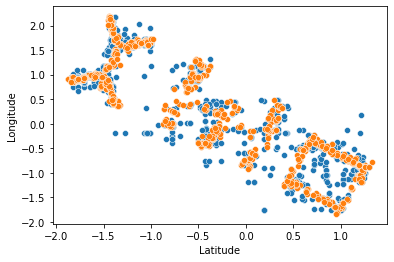

In [27]:
plot_predictions('localization_DT.eps')

### Random Forest

In [28]:
rfr_lat = RandomForestRegressor(random_state=123)
rfr_lon = RandomForestRegressor(random_state=123)
rfr_lat.fit(X, lat)
rfr_lon.fit(X, lon)

RandomForestRegressor(random_state=123)

In [29]:
print("Latitude training score:", rfr_lat.score(X,lat))
print("Longitude training score:", rfr_lon.score(X,lon))

Latitude training score: 0.9960426150967083
Longitude training score: 0.9974166036057185


In [30]:
pred_lat = rfr_lat.predict(X_test)
pred_lon = rfr_lon.predict(X_test)
results.loc['RF-default',:] = compute_metrics(lat_test, pred_lat,lon_test, pred_lon)

In [31]:
results

,Latitude MSE,Latitude R2,Longitude MSE,Longitude R2
DT-default,0.081313,0.926169,0.019434,0.979503
RF-default,0.039852,0.963815,0.011751,0.987606


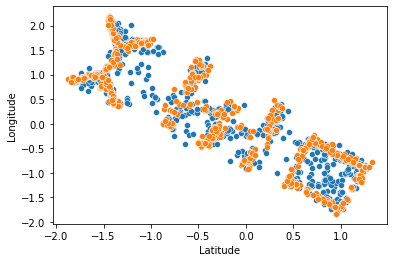

In [32]:
plot_predictions('localization_RF.eps')

### Hyperparameter tunning

In [33]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 150, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 12,15,18,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, None], 'min_samples_split': [10, 12, 15, 18, 20], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
##rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
##rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Print the best parameters
##rf_random.best_params_

In [35]:
rf_lat = RandomForestRegressor(n_estimators=850,
                               min_samples_split=10,
                               min_samples_leaf=1,
                               max_features='sqrt',
                               max_depth=130,
                               bootstrap=False,
                               random_state=123)
rf_lon = RandomForestRegressor(n_estimators=850,
                               min_samples_split=10,
                               min_samples_leaf=1,
                               max_features='sqrt',
                               max_depth=130,
                               bootstrap=False,
                               random_state=123)

In [36]:
rf_lat.fit(X, lat)
rf_lon.fit(X, lon)

RandomForestRegressor(bootstrap=False, max_depth=130, max_features='sqrt',
                      min_samples_split=10, n_estimators=850, random_state=123)

In [37]:
print("Latitude training score:", rf_lat.score(X,lat))
print("Longitude training score:", rf_lon.score(X,lon))

Latitude training score: 0.9961441630040215
Longitude training score: 0.9974912856654738


In [38]:
pred_lat = rf_lat.predict(X_test)
pred_lon = rf_lon.predict(X_test)
results.loc['RF-Best',:] = compute_metrics(lat_test, pred_lat,lon_test, pred_lon)

In [39]:
results

,Latitude MSE,Latitude R2,Longitude MSE,Longitude R2
DT-default,0.081313,0.926169,0.019434,0.979503
RF-default,0.039852,0.963815,0.011751,0.987606
RF-Best,0.019244,0.982527,0.006371,0.99328


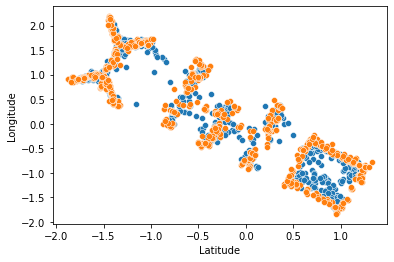

In [40]:
plot_predictions('localization_RF-Best.eps')

### Neural Networks

In [41]:
from sklearn.neural_network import MLPRegressor

In [42]:
nn_lat = MLPRegressor(hidden_layer_sizes=[16,16,16],
                         alpha=1,
                         activation='relu',
                         max_iter=2000,
                         solver='adam',
                         random_state=123,
                         verbose=False,
                         tol=1e-6,
                         early_stopping=True,
                         learning_rate_init=0.0001)
nn_lon = MLPRegressor(hidden_layer_sizes=[16,16,16],
                         alpha=1,
                         activation='relu',
                         max_iter=2000,
                         solver='adam',
                         random_state=123,
                         verbose=False,
                         tol=1e-6,
                         early_stopping=True,
                         learning_rate_init=0.0001)

In [43]:
nn_lat.fit(X,lat)
nn_lon.fit(X,lon)

MLPRegressor(alpha=1, early_stopping=True, hidden_layer_sizes=[16, 16, 16],
             learning_rate_init=0.0001, max_iter=2000, random_state=123,
             tol=1e-06)

In [44]:
print("Latitude training score:", nn_lat.score(X,lat))
print("Longitude training score:", nn_lon.score(X,lon))

Latitude training score: 0.9867901138075028
Longitude training score: 0.9914123545383635


In [45]:
pred_lat = nn_lat.predict(X_test)
pred_lon = nn_lon.predict(X_test)
results.loc['NN',:] = compute_metrics(lat_test, pred_lat, lon_test, pred_lon)

In [46]:
results

,Latitude MSE,Latitude R2,Longitude MSE,Longitude R2
DT-default,0.081313,0.926169,0.019434,0.979503
RF-default,0.039852,0.963815,0.011751,0.987606
RF-Best,0.019244,0.982527,0.006371,0.99328
NN,0.07055,0.935942,0.033436,0.964734


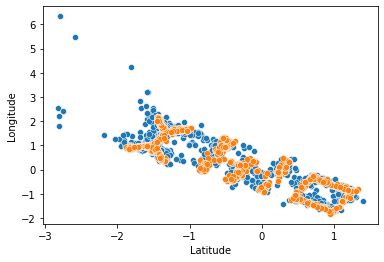

In [47]:
plot_predictions('localization_NN.eps')